# **Liver Segmentaion**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import required libraries and packages

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.python.ops.gen_dataset_ops import model_dataset

In [ ]:
# File paths for images and masks
image_dir = "/content/drive/MyDrive/Liver Cancer detection/TumorSegmentation/Enhanced_grey"
mask_dir = "/content/drive/MyDrive/Liver Cancer detection/TumorSegmentation/segmented_masks"

In [ ]:
# Data generators for images and masks
image_datagen = ImageDataGenerator(rescale=1.0 / 255)

mask_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
# Create paired generators for images and masks
def paired_generator(image_dir, mask_dir, target_size=(256, 256), batch_size=16, seed=42):
    image_generator = image_datagen.flow_from_directory(
        image_dir,
        target_size=target_size,
        color_mode="grayscale",
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_directory(
        mask_dir,
        target_size=target_size,
        color_mode="grayscale",
        class_mode=None,
        batch_size=batch_size,
        seed=seed,
    )

    while True:
        images = next(image_generator)
        masks = next(mask_generator)

        # Ensure both images and masks are the same shape
        if images.shape[0] != masks.shape[0]:
            raise ValueError(f"Batch size mismatch: {images.shape[0]} vs {masks.shape[0]}")

        # Convert to TensorFlow tensors and process
        images = tf.convert_to_tensor(images)  # Convert NumPy to TensorFlow tensor
        images = tf.image.grayscale_to_rgb(images)  # Convert grayscale to RGB for EfficientNet

        masks = tf.convert_to_tensor(masks)  # Convert NumPy to TensorFlow tensor
        masks = tf.expand_dims(masks, axis=-1)  # Ensure masks have a single channel

        yield images, masks

In [ ]:
import os

num_images = sum([len(files) for _, _, files in os.walk(image_dir)])
num_masks = sum([len(files) for _, _, files in os.walk(mask_dir)])
print(f"Number of images: {num_images}, Number of masks: {num_masks}")

Number of images: 0, Number of masks: 0


## **Unet Model**

In [ ]:
# Build U-Net with EfficientNetB0 encoder
def build_unet(input_shape=(256, 256, 3)):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

    # Encoder: EfficientNetB0
    x = base_model.output

    # Decoder OG
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    # Output layer: Single-channel for grayscale mask
    output = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)
    output = layers.UpSampling2D((4,4))(output)

    # Create and compile the model
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
# Visualization function to show both dataset images and model predictions
def visualize_data(generator, model, num_images=5):
    images, masks = next(generator)  # Get a batch of images and masks
    images = images.numpy()  # Convert tensors to NumPy arrays for visualization
    masks = masks.numpy()

    # Get model predictions
    predictions = model.predict(images)  # Predicted masks from the model

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.title("Input Image")
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.axis("off")

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.title("Ground Truth Mask")
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Create data generator
train_gen = paired_generator(image_dir, mask_dir)

# Build and train the model
model = build_unet()
model.fit(train_gen, epochs=20, steps_per_epoch=100)  # Adjust steps_per_epoch as needed

Found 3293 images belonging to 3 classes.
Found 3293 images belonging to 3 classes.
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1380s 13s/step - accuracy: 0.9049 - loss: 0.1672
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1240s 12s/step - accuracy: 0.9592 - loss: 0.0631
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9629 - loss: 0.0524
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9657 - loss: 0.0464
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9671 - loss: 0.0432
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9667 - loss: 0.0429
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9670 - loss: 0.0387
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9707 - loss: 0.0356
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9702 - loss: 0.0341
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.9703 - loss: 0.0336
Epoch 11/20
100/100 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


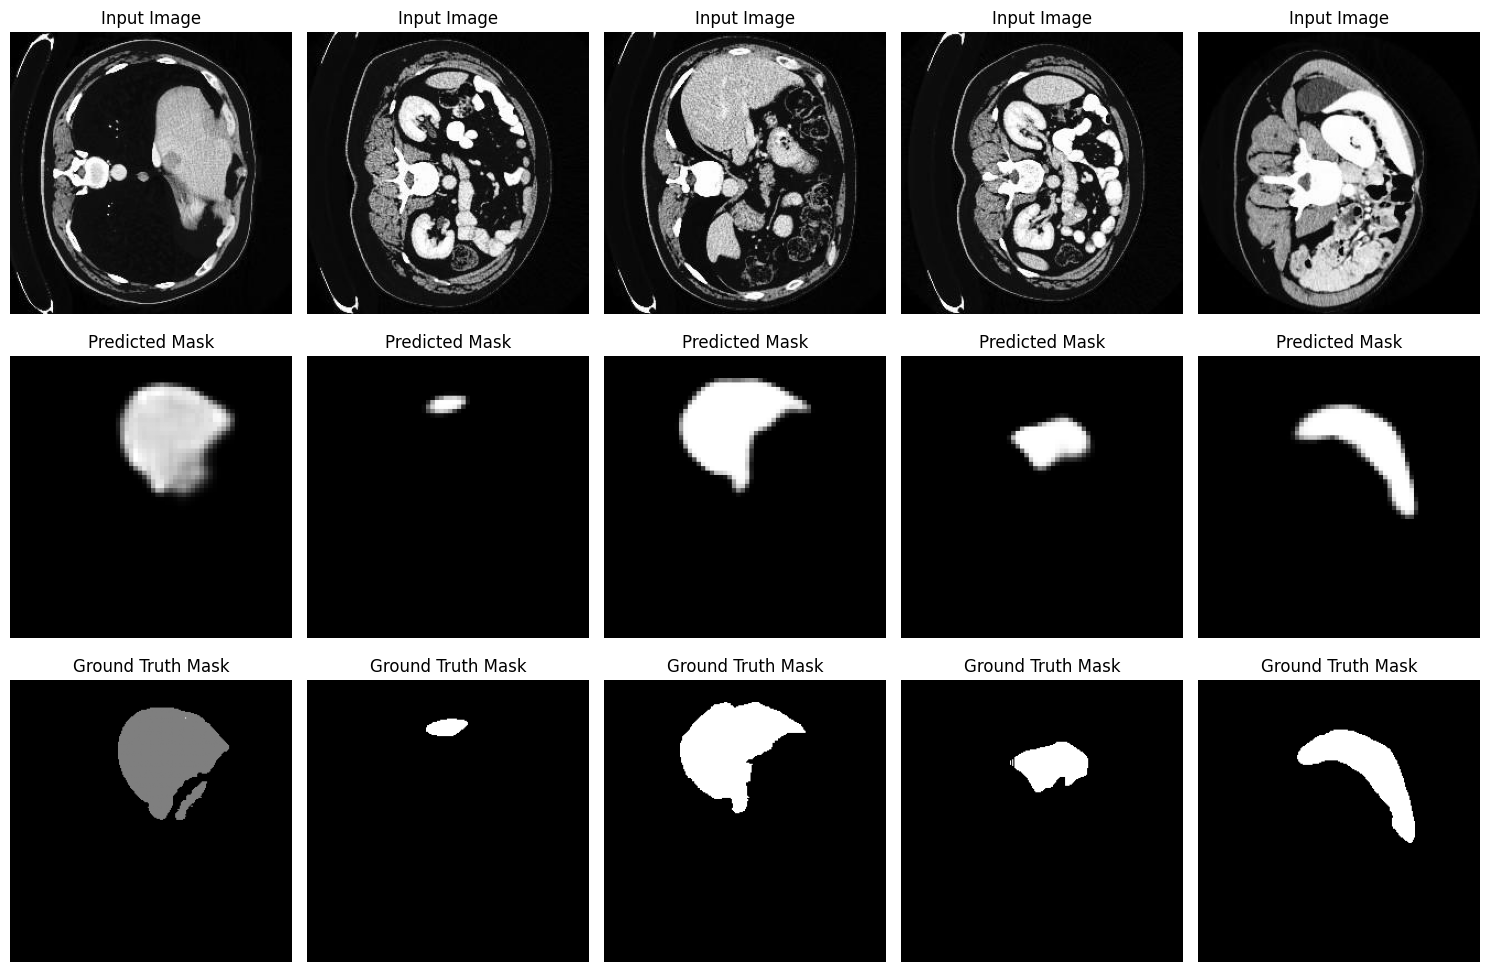

In [ ]:
# After training the model, visualize the predictions
visualize_data(train_gen, model)  # Pass the trained model and generator to visualize

### Save Model in keras and h5 format

In [ ]:
model.save("unet_efficientnet_model.h5")
model.save("unet_efficientnet_model.keras")

Test the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = '/content/liver.jpg'
img = cv2.imread(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img = img / 255.0
img = np.expand_dims(img, axis=0)
img.shape

(1, 256, 256, 3)

In [ ]:
model = load_model('unet_efficientnet_model.h5')
seg_img = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


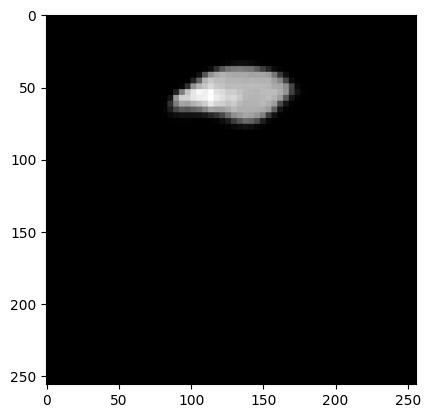

In [ ]:
plt.imshow(seg_img[0], cmap='gray')

Load images, masks and label individually

In [ ]:
import os
import cv2
import numpy as np

# Paths to the directories
enhanced_grey_dir = '/content/drive/MyDrive/Liver Cancer detection/TumorSegmentation/Enhanced_grey'
segmented_masks_dir = '/content/drive/MyDrive/Liver Cancer detection/TumorSegmentation/segmented_masks'

# Lists to store the images, masks, and labels
images = []
masks = []
labels = []

# A function to get the label based on the folder name
def get_label_from_folder(folder_name):
    if 'Benign' in folder_name:
        return 'Benign'
    elif 'Malignant' in folder_name:
        return 'Malignant'
    elif 'Normal' in folder_name:
        return 'Normal'
    return None

# Iterate through each subfolder in Enhanced_grey and segmented_masks
for label in ['Benign', 'Malignant', 'Normal']:
    # Iterate through volumes in each label folder
    label_dir_enhanced = os.path.join(enhanced_grey_dir, label)
    label_dir_masked = os.path.join(segmented_masks_dir, label)

    for volume in os.listdir(label_dir_enhanced):
        volume_dir_enhanced = os.path.join(label_dir_enhanced, volume)
        volume_dir_masked = os.path.join(label_dir_masked, volume)

        # Iterate through the images in the volume folder
        for img_filename in os.listdir(volume_dir_enhanced):
            if img_filename.endswith('.jpg'):
                # Extract the slice number from the filename (e.g., 'slice_305')
                slice_number = img_filename.split('_')[-1].split('.')[0]

                # Construct the corresponding mask filename
                mask_filename = f"slice_25_{slice_number}.png"
                mask_path = os.path.join(volume_dir_masked, mask_filename)

                if os.path.exists(mask_path):
                    # Load the image and mask
                    img_path = os.path.join(volume_dir_enhanced, img_filename)
                    image = cv2.imread(img_path)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    # Append image, mask, and label to the lists
                    images.append(image)
                    masks.append(mask)
                    labels.append(get_label_from_folder(label_dir_enhanced))

# Convert lists to numpy arrays (optional, depending on use)
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)


# Print the shape of the loaded data
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (2509, 256, 256, 3)
Masks shape: (2509, 512, 512)
Labels shape: (2509,)


**Extract Liver portion from the CT scan image**

In [ ]:
def segment_liver(img, mask):
    """
    This function takes the image and its corresponding mask, applies the mask on the image,
    and returns the masked image.
    """
    image_size = (224, 224)
    # Resize the image and mask
    img_resized = cv2.resize(img, image_size)
    mask_resized = cv2.resize(mask, image_size)

    # Apply the mask to the image (mask should be binary, 0 for background, 1 for liver)
    img_masked = np.copy(img_resized)
    img_masked[mask_resized == 0] = 0  # Set the background to black

    # Optionally, you can perform other preprocessing like normalization, etc.
    return img_masked

Visualize image, mask and segmented liver

In [ ]:
import matplotlib.pyplot as plt

img_masked = preprocess_image(images[1015], resized_masks[1015])

plt.figure(figsize=(15, 9))
plt.subplot(1, 3, 1)
plt.imshow(images[1015])
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(resized_masks[1015], cmap='gray')
plt.title('Mask')

plt.subplot(1, 3, 3)
plt.imshow(img_masked, cmap='gray')
plt.title('segmented liver')

plt.show()
print(f"Label: {labels[1015]}")